In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """
    S: Spot price (can be numpy array)
    K: Strike price
    T: Time to expiry (years)
    r: Risk-free rate
    sigma: Volatility
    Returns: call price, delta
    """
    S = np.array(S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta


In [3]:

def get_samples(initial_price,expiry = 1.0,strike = 100.0 ,volatility = 0.2,r = 0.02):
    n_path= initial_price.size
    s = initial_price * np.exp((r-0.5*volatility**2)*expiry + volatility * np.random.standard_normal(size=n_path)*np.sqrt(expiry))
    v = np.exp(-r*expiry)*np.maximum(s-strike, 0)
    dv =  np.exp(-r*expiry)*(s>=strike) 
    #v = torch.tensor(v, dtype=torch.float32).view(-1, 1)
    #dv = torch.tensor(dv, dtype=torch.float32).view(-1, 1)
    return v,dv


In [4]:
expiry = 0.1
volatility = 0.2

initial_price = np.linspace(50, 200, 10000)  # Initial stock price
real_price, real_delta = black_scholes_call(initial_price, 100.0,expiry, 0.02,volatility)

In [5]:
val_scaler = StandardScaler()
grad_scaler = StandardScaler()
input_scaler = StandardScaler()

In [6]:
np.random.seed(42)
y, grad_y =get_samples(initial_price,expiry = expiry,strike = 100.0 ,volatility = volatility,r = 0.02)

y_scaled = val_scaler.fit_transform(y.reshape(-1, 1)).reshape(-1)
grad_y_scaled = grad_scaler.fit_transform(grad_y.reshape(-1, 1)).reshape(-1)

y_scaled  = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)
grad_y_scaled = torch.tensor(grad_y_scaled, dtype=torch.float32).view(-1, 1)
X = input_scaler.fit_transform(initial_price.reshape(-1, 1)).reshape(-1)
X = torch.tensor(X, dtype=torch.float32).view(-1, 1)


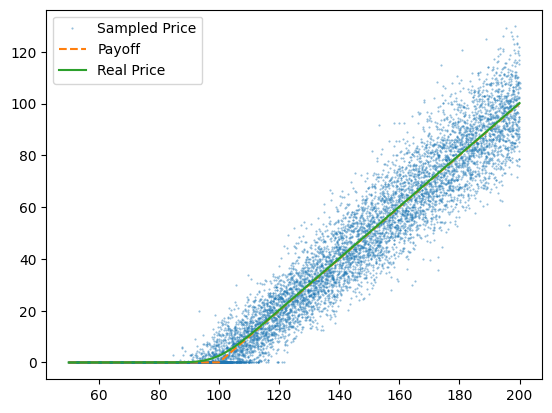

In [7]:
plt.plot(initial_price, y, '.', markersize=1, label='Sampled Price',alpha=0.5)
plt.plot(initial_price,np.maximum(initial_price - 100, 0), '--', markersize=1, label='Payoff')
plt.plot(initial_price, real_price, '-', markersize=1, label='Real Price')

plt.legend()

In [8]:

# Define the model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.Softplus(beta=10.0),
            nn.Linear(100, 100),
            nn.Softplus(beta=10.0),
            nn.Linear(100, 100),
            nn.Softplus(beta=10.0),
            nn.Linear(100, 1,bias=True),
        )

    def forward(self, x):
        return self.layers(x)

model = Net()


In [9]:

# Training loop
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [10]:
lambda_grad = 0.5
for epoch in range(2000):
    optimizer.zero_grad()

    X.requires_grad_(True)
    y_pred = model(X)

    # Compute gradients of the model output w.r.t. inputs
    grad_outputs = torch.ones_like(y_pred)
    grad_pred = torch.autograd.grad(
        outputs=y_pred, inputs=X,
        grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    # Compute loss: MSE on value and gradient
    loss_val = nn.functional.mse_loss(y_pred, y_scaled)
    loss_grad = nn.functional.mse_loss(grad_pred, grad_y_scaled)
    loss = (1 - lambda_grad) * loss_val + lambda_grad * loss_grad

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Value Loss: {loss_val.item():.6f}, Grad Loss: {loss_grad.item():.6f}")


Epoch 0, Loss: 1.011583, Value Loss: 1.050790, Grad Loss: 0.972375
Epoch 200, Loss: 0.239702, Value Loss: 0.210240, Grad Loss: 0.269164
Epoch 400, Loss: 0.239690, Value Loss: 0.209675, Grad Loss: 0.269705
Epoch 600, Loss: 0.239671, Value Loss: 0.209756, Grad Loss: 0.269585
Epoch 800, Loss: 0.239623, Value Loss: 0.209714, Grad Loss: 0.269531
Epoch 1000, Loss: 0.239591, Value Loss: 0.209726, Grad Loss: 0.269456
Epoch 1200, Loss: 0.239568, Value Loss: 0.209747, Grad Loss: 0.269389
Epoch 1400, Loss: 0.239543, Value Loss: 0.209625, Grad Loss: 0.269460
Epoch 1600, Loss: 0.239562, Value Loss: 0.213576, Grad Loss: 0.265548
Epoch 1800, Loss: 0.239504, Value Loss: 0.209682, Grad Loss: 0.269326


In [15]:

# ===== Generate Test Data =====
n_test = 500
x_test = np.sort(np.random.uniform(70, 150, n_test))  # Initial stock price

X_test =torch.tensor(input_scaler.inverse_transform(x_test.reshape(-1, 1)).reshape(-1), dtype=torch.float32).view(-1, 1)  # uniform in [-2, 2]^2
y_test, grad_test = black_scholes_call(x_test, 100.0,expiry, 0.02,volatility)

# ===== Predict with Trained Model =====
X_test.requires_grad_(True)
y_pred_test = model(X_test)

# Compute predicted gradients
grad_pred_test = torch.autograd.grad(
    outputs=y_pred_test, inputs=X_test,
    grad_outputs=torch.ones_like(y_pred_test),
    create_graph=False, retain_graph=False, only_inputs=True
)[0]
y_pred_test = val_scaler.inverse_transform(y_pred_test.detach().numpy().reshape(-1, 1)).reshape(-1)
grad_pred_test = grad_scaler.inverse_transform(grad_pred_test.detach().numpy().reshape(-1, 1)).reshape(-1)

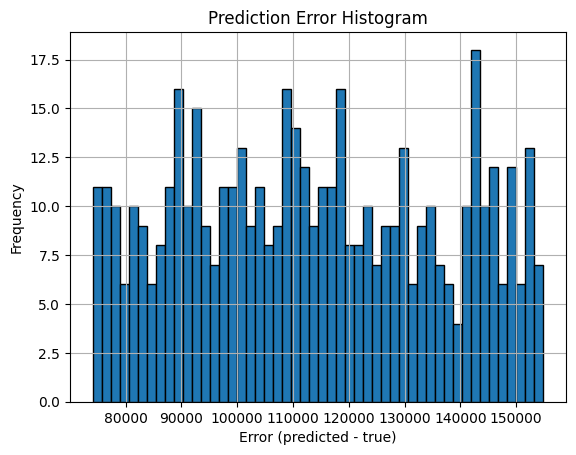

In [16]:
# ===== Value Error Histogram =====
errors = (y_pred_test - y_test)
plt.hist(errors, bins=50, edgecolor='black')
plt.title("Prediction Error Histogram")
plt.xlabel("Error (predicted - true)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


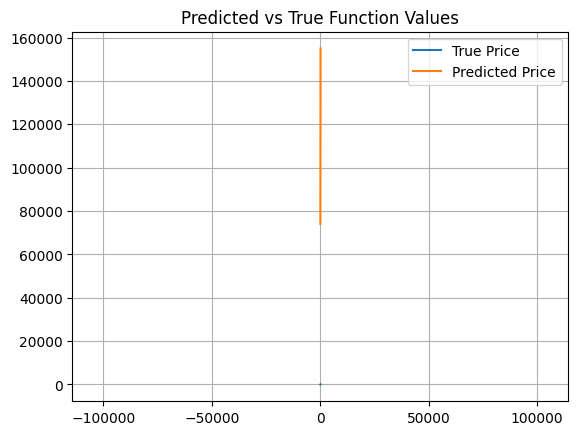

In [17]:

# ===== Value Scatter Plot =====
#plt.scatter(y_test, y_pred_test.detach().numpy(), alpha=0.6)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.plot(x_test, y_test, '-', markersize=1, label='True Price')
plt.plot(x_test, y_pred_test, '-', markersize=1, label='Predicted Price')
plt.legend()
plt.title("Predicted vs True Function Values")
#plt.xlabel("True f(x)")
#plt.ylabel("Predicted f(x)")
plt.grid(True)
plt.axis('equal')
plt.show()


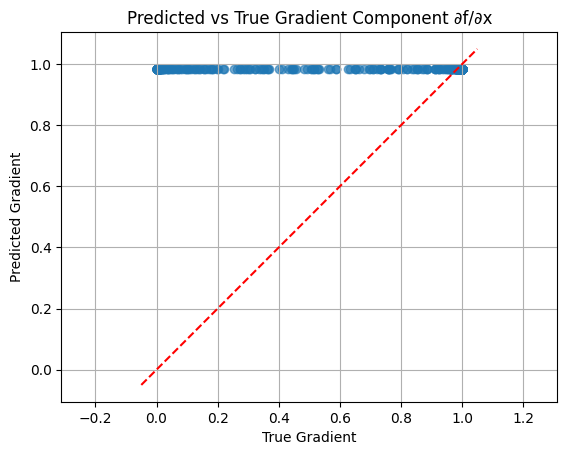

In [14]:

# ===== Gradient Scatter Plots =====

plt.scatter(
    grad_test,
    grad_pred_test,
    alpha=0.6
)
xx = plt.gca().get_xlim()
plt.plot(xx, xx, 'r--')

plt.title(f"Predicted vs True Gradient Component ∂f/∂x")
plt.xlabel("True Gradient")
plt.ylabel("Predicted Gradient")
plt.grid(True)
plt.axis('equal')
plt.show()
